# Heres some stuff from my hurricane project!

## Imports

In [71]:
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import interpolate
from microSWIFTtelemetry import pull_telemetry_as_var
import pickle
import colorcet as cc
from scipy import interpolate

#xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))



## Compiling bouy data

In [72]:



def concatenate_drifters(drifter_dict: dict) -> pd.DataFrame:
    """
    Concatenate a dictionary of individual drifter DataFrames into a single,
    multi-index DataFrame.  Drop the observations that do not contain waves
    (remove off-hour pressure and temperature observations).

    Args:
        drifter_dict (dict): individual drifter DataFrames keyed by id.

    Returns:
        DataFrame: concatenated drifters
    """
    drifter_df = (
        pd.concat(drifter_dict, names=['id', 'time'])
        .dropna(subset='energy_density')
    )
    return drifter_df

DRIFTER_DATA_PATH = './hurricane_idalia_drifter_data_v3.pickle'

with open(DRIFTER_DATA_PATH, 'rb') as handle:
    drifter_data = pickle.load(handle)

# Concatenate the indivudal drifter DataFrames by type
microswift_df = concatenate_drifters(drifter_data['microswift'])
dwsd_df = concatenate_drifters(drifter_data['dwsd'])
spotter_df = concatenate_drifters(drifter_data['spotter'])



# Create a drifter type column
microswift_df['drifter_type'] = 'microswift'
dwsd_df['drifter_type'] = 'dwsd'
spotter_df['drifter_type'] = 'spotter'

# Combine all drifters into a single DataFrame.
drifter_df = (pd.concat([microswift_df, dwsd_df, spotter_df])
              .sort_index(level=['id', 'time'], ascending=True))

drifter_df = drifter_df.loc[drifter_df.latitude >= 27]

#wind data

drifter_wind_variables_df = pd.read_pickle(r'drifter_wind_variables_df.pickle')
drifter_df = drifter_df.join(drifter_wind_variables_df)

#bouy identification

drifterids = drifter_df.index.get_level_values(level="id").unique()

## getting NOAA data

In [73]:
IBTRACS_BASE_URL = ('https://www.ncei.noaa.gov/data/international-best-'
                    'track-archive-for-climate-stewardship-ibtracs/'
                    'v04r00/access/csv/')
IBTRACS_BASE_CSV = f'ibtracs.last3years.list.v04r00.csv'
IBTRACS_PATH = IBTRACS_BASE_URL + IBTRACS_BASE_CSV
ibtracs_df = pd.read_csv(IBTRACS_PATH, low_memory=False)
ibtracs_df = (ibtracs_df
    .query('NAME == "IDALIA"')
    .assign(ISO_TIME = lambda df: pd.to_datetime(df['ISO_TIME'], utc=True))
    .set_index('ISO_TIME', drop=True)
    .assign(LAT = lambda df: df['LAT'].astype(np.float64))
    .assign(LON = lambda df: df['LON'].astype(np.float64))
)


## interpolation station

In [74]:


for drifter in drifterids:
    
    # latitude interpolation
    x = ibtracs_df.index
    y = ibtracs_df['LAT']
    f = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")
    latxnew = drifter_df.loc[drifter].index #correspond to the microswift times
    latynew = f(pd.to_numeric(latxnew))   # use interpolation function returned by `interp1d`
   
    # Longiutude interpolation
    x = ibtracs_df.index
    y = ibtracs_df['LON']
    f = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")
    lonxnew = drifter_df.loc[drifter].index #correspond to the microswift times
    lonynew = f(pd.to_numeric(lonxnew))   # use interpolation function returned by `interp1d`
   
    #rmw interpolation
    x = ibtracs_df.index
    y = ibtracs_df['USA_RMW']
    f = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")
    rmwxnew = drifter_df.loc[drifter].index #correspond to the microswift times
    rmwynew = f(pd.to_numeric(rmwxnew))   # use interpolation function returned by `interp1d`

    # Assign to dataframe
    drifter_df.loc[drifter, 'stormlatitude']=latynew
    drifter_df.loc[drifter, 'stormlongitude']=lonynew
    drifter_df.loc[drifter, 'stormrmwkm']=rmwynew * 1.852
    

## Converting latitide and longitude to polar coordinates

In [75]:
def great_circle_pairwise(
    longitude_a: np.ndarray,
    latitude_a: np.ndarray,
    longitude_b: np.ndarray,
    latitude_b: np.ndarray,
    earth_radius: float = 6378.137,
    mod_bearing: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
       # Convert decimal degrees to radians
    longitude_a_rad, latitude_a_rad = map(np.radians, [longitude_a, latitude_a])
    longitude_b_rad, latitude_b_rad = map(np.radians, [longitude_b, latitude_b])

    # Difference longitude and latitude
    longitude_difference = longitude_b_rad - longitude_a_rad
    latitude_difference = latitude_b_rad - latitude_a_rad

    # Haversine formula
    a_1 = np.sin(latitude_difference / 2) ** 2
    a_2 = np.cos(latitude_a_rad)
    a_3 = np.cos(latitude_b_rad)
    a_4 = np.sin(longitude_difference / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a_1 + a_2 * a_3 * a_4))
    distance_km = earth_radius * c

    # True bearing
    bearing_num = np.cos(latitude_b_rad) * np.sin(-longitude_difference)
    bearing_den_1 = np.cos(latitude_a_rad) * np.sin(latitude_b_rad)
    bearing_den_2 = - np.sin(latitude_a_rad) * np.cos(latitude_b_rad) * np.cos(longitude_difference)
    bearing_deg = -np.degrees(np.arctan2(bearing_num, bearing_den_1 + bearing_den_2))

    if mod_bearing:
        bearing_deg = bearing_deg % 360

    return distance_km, bearing_deg


drifter_df['storm_distance'], drifter_df['storm_bearing'] = great_circle_pairwise(
    longitude_a = drifter_df['stormlongitude'],
    latitude_a = drifter_df['stormlatitude'],
    longitude_b = drifter_df['longitude'],
    latitude_b = drifter_df['latitude'],
    earth_radius = 6378.137,
    mod_bearing = True
)


## Interpolating storm direction

In [76]:

y = np.unwrap(pd.to_numeric(ibtracs_df.STORM_DIR), period=360)
x = ibtracs_df.index
interp_func = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")

for drifter in drifterids:
    xnew = drifter_df.loc[drifter].index
    ynew = interp_func(pd.to_numeric(xnew))
    drifter_df.loc[drifter,'storm_direction'] = ynew % 360

## putting it all in an xy plane with the direction Idalia is moving as the y axis

In [77]:
anglefromstormdir = (drifter_df['storm_bearing']-drifter_df['storm_direction'])%360
xstorm = np.sin(anglefromstormdir*np.pi/180)* drifter_df.storm_distance
ystorm = np.cos(anglefromstormdir*np.pi/180)* drifter_df.storm_distance
drifter_df['anglefromstormdir'] = anglefromstormdir
drifter_df['xstorm'] = xstorm
drifter_df['ystorm'] = ystorm

## graphs!

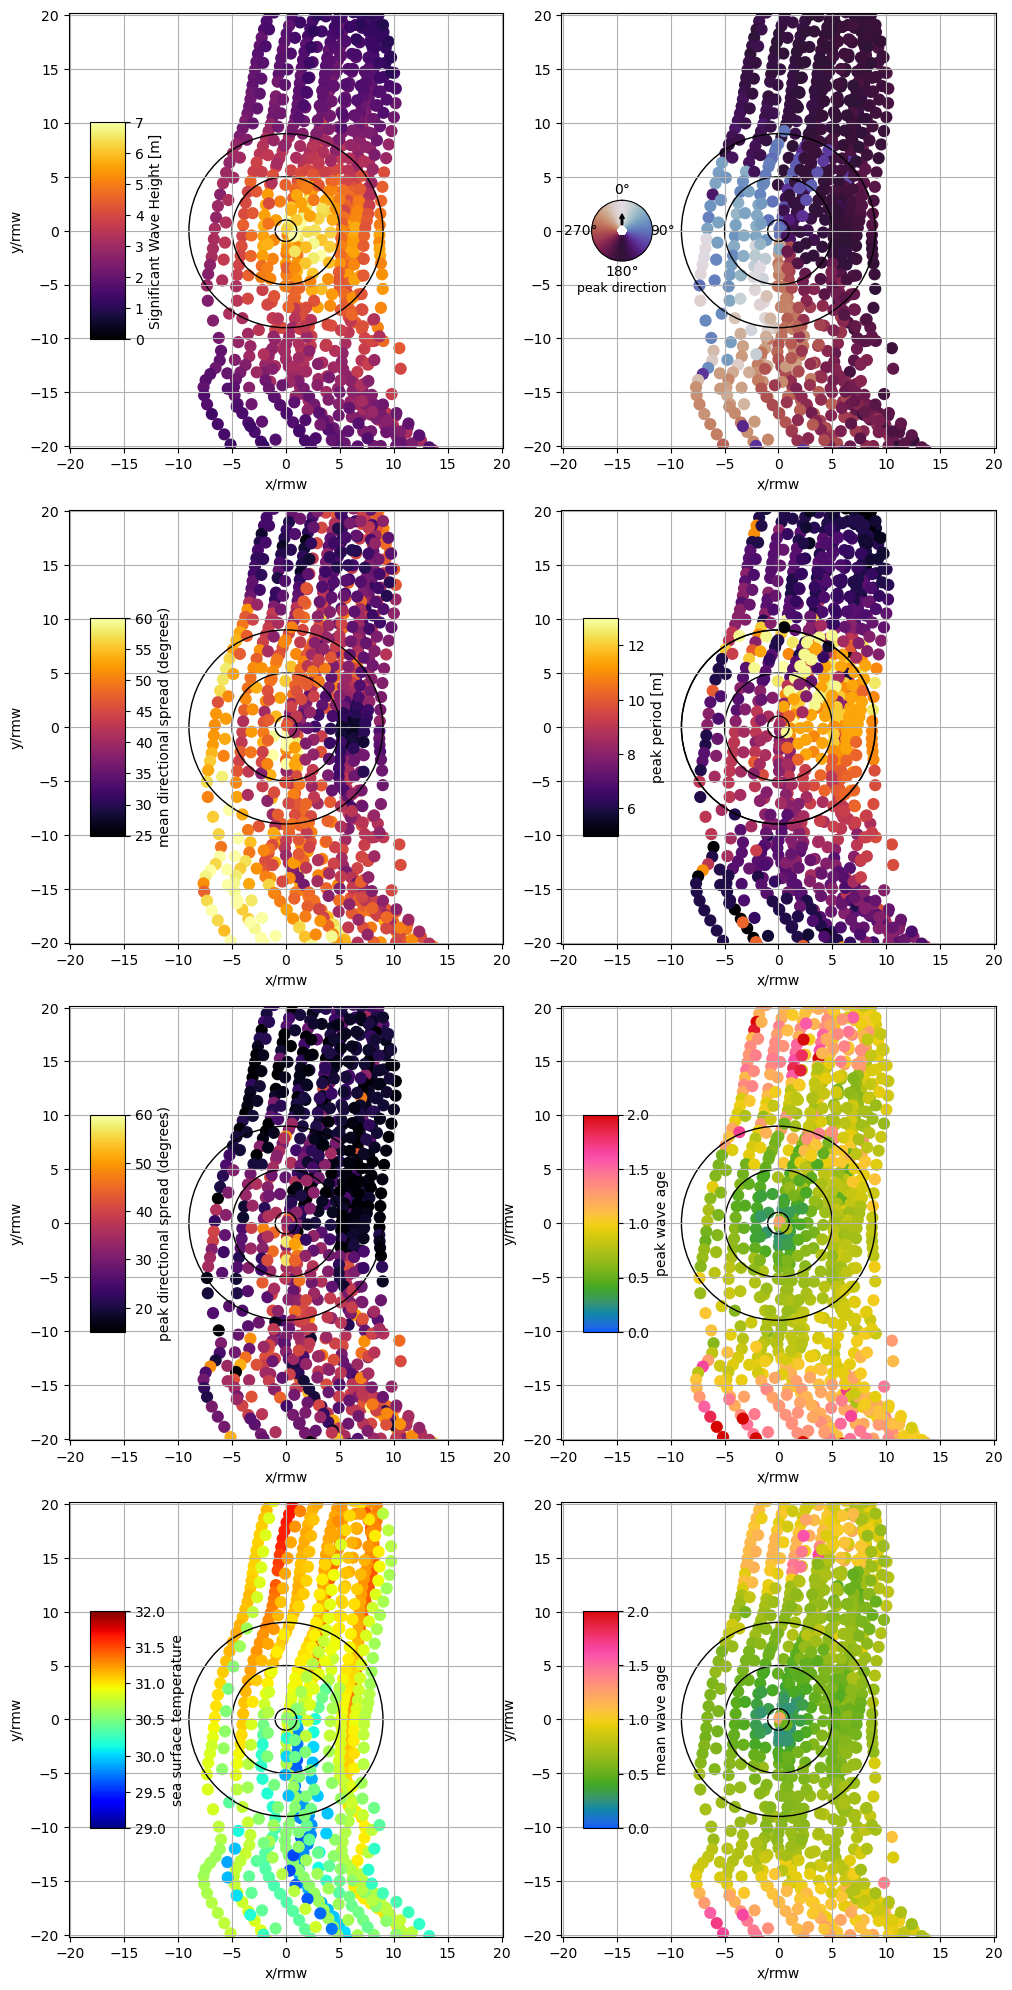

In [78]:

cmap = 'inferno'
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
fig.set_size_inches(10, 20)
fig.tight_layout()


start_date = pd.Timestamp('2023-08-30T00:00', tz='utc')
end_date = pd.Timestamp('2023-08-30T15:00', tz='utc')
time_slice = slice(start_date, end_date)
time_slice_no_tz = slice(start_date.tz_localize(None), end_date.tz_localize(None))
rmwkm = ibtracs_df.loc[time_slice].USA_RMW.apply(float).mean()*1.852

# first plot
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.significant_height
norm = plt.Normalize(0,7)
sc = ax[0,0].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[0,0].set_xlabel('x/rmw')
ax[0,0].set_ylabel('y/rmw')
ax[0,0].grid()
ax[0,0].set_xlim(np.array([-400, 400]) / rmwkm)
ax[0,0].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0),1, fill=False)
ax[0,0].set_aspect( 1 ) 
ax[0,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0),5, fill=False)
ax[0,0].set_aspect( 1 ) 
ax[0,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[0,0].set_aspect( 1 ) 
ax[0,0].add_patch( cc ) 
ax_cbar = ax[0,0].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc, cax=ax_cbar, label='Significant Wave Height [m]')

#graph2
cmap = 'twilight'
plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=c = (drifter_df['peak_direction']-drifter_df['storm_direction'])%360
norm = mpl.colors.Normalize(vmin=0, vmax=360)
sc = ax[0,1].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[0,1].set_xlabel('x/rmw')
ax[0,1].grid()
circle=plt.Circle((0,0),100)
ax[0,1].set_xlim(np.array([-400, 400]) / rmwkm)
ax[0,1].set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[0,1].set_aspect( 1 ) 
ax[0,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[0,1].set_aspect( 1 ) 
ax[0,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[0,1].set_aspect( 1 ) 
ax[0,1].add_patch( cc ) 


legend_location = [0.07, 0.43,.14,.14]  # x, y, width, height
ax2 = ax[0,1].inset_axes(legend_location, projection='polar')
azimuths = np.arange(0, 361, 1)
zeniths = np.linspace(0.2, 1, 10)
values = azimuths * np.ones((len(zeniths), len(azimuths)))
ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmap, norm=norm)
ax2.set_yticks([])
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.xaxis.grid(False)
ax2.tick_params(pad=-3,labelsize=10)
ax2.set_ylim([0, 1])
ax2.set_xticks([0, np.pi/2, np.pi])
ax2.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])

ax3 = ax[0,1].inset_axes(legend_location)
ax2.set_xlabel('peak direction', fontsize=9, labelpad=2)



arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()



#peak period, how fast waves go up and down
cmap = 'inferno'
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.peak_period
norm = plt.Normalize(5,13)
sc = ax[1,1].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[1,1].set_xlabel('x/rmw')
ax[1,1].grid()
ax[1,1].set_xlim(np.array([-400, 400]) / rmwkm)
ax[1,1].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[1,1].set_aspect( 1 ) 
ax[1,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[1,1].set_aspect( 1 ) 
ax[1,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[1,1].set_aspect( 1 ) 
ax[1,1].add_patch( cc ) 

ax[1,1].set_aspect( 1 ) 
ax[1,1].add_patch( cc ) 
ax_cbar = ax[1,1].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc, cax=ax_cbar, label='peak period [m]')



#mean directional spread
cmap = 'inferno'
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.mean_directional_spread
norm = plt.Normalize(25,60)
sc = ax[1,0].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[1,0].set_xlabel('x/rmw')
ax[1,0].set_ylabel('y/rmw')
ax[1,0].grid()
ax[1,0].set_xlim(np.array([-400, 400]) / rmwkm)
ax[1,0].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[1,0].set_aspect( 1 ) 
ax[1,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[1,0].set_aspect( 1 ) 
ax[1,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[1,0].set_aspect( 1 ) 
ax[1,0].add_patch( cc ) 
ax_cbar = ax[1,0].inset_axes([0.05, 0.25, 0.08, 0.5])

fig.colorbar(sc, cax=ax_cbar, label='mean directional spread (degrees)')
#peak spread
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.peak_directional_spread
norm = plt.Normalize(15,60)
sc = ax[2,0].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[2,0].set_xlabel('x/rmw')
ax[2,0].set_ylabel('y/rmw')
ax[2,0].grid()
ax[2,0].set_xlim(np.array([-400, 400]) / rmwkm)
ax[2,0].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[2,0].set_aspect( 1 ) 
ax[2,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[2,0].set_aspect( 1 ) 
ax[2,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[2,0].set_aspect( 1 ) 
ax[2,0].add_patch( cc ) 
ax_cbar = ax[2,0].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc, cax=ax_cbar, label='peak directional spread (degrees)')

#peak wave age
cmap = "cet_diverging_rainbow_bgymr_45_85_c67"
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.peak_wave_age
norm = plt.Normalize(0,2)
sc = ax[2,1].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[2,1].set_xlabel('x/rmw')
ax[2,1].set_ylabel('y/rmw')
ax[2,1].grid()
ax[2,1].set_xlim(np.array([-400, 400]) / rmwkm)
ax[2,1].set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[2,1].set_aspect( 1 ) 
ax[2,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[2,1].set_aspect( 1 ) 
ax[2,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[2,1].set_aspect( 1 ) 
ax[2,1].add_patch( cc ) 
ax_cbar = ax[2,1].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc,  cax=ax_cbar, label='peak wave age')

#mean wave age
cmap = "cet_diverging_rainbow_bgymr_45_85_c67"
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.mean_wave_age
norm = plt.Normalize(0,2)
sc = ax[3,1].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[3,1].set_xlabel('x/rmw')
ax[3,1].set_ylabel('y/rmw')
ax[3,1].grid()
ax[3,1].set_xlim(np.array([-400, 400]) / rmwkm)
ax[3,1].set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[3,1].set_aspect( 1 ) 
ax[3,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[3,1].set_aspect( 1 ) 
ax[3,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[3,1].set_aspect( 1 ) 
ax[3,1].add_patch( cc ) 
ax_cbar = ax[3,1].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc,  cax=ax_cbar, label='mean wave age')

#sea surface temperature
cmap="jet"
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.sea_surface_temperature
norm = plt.Normalize(29,32)
sc = ax[3,0].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[3,0].set_xlabel('x/rmw')
ax[3,0].set_ylabel('y/rmw')
ax[3,0].grid()
ax[3,0].set_xlim(np.array([-400, 400]) / rmwkm)
ax[3,0].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0),1, fill=False)
ax[3,0].set_aspect( 1 ) 
ax[3,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0),5, fill=False)
ax[3,0].set_aspect( 1 ) 
ax[3,0].add_patch( cc )

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[3,0].set_aspect( 1 ) 
ax[3,0].add_patch( cc ) 
ax_cbar = ax[3,0].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc, cax=ax_cbar, label='sea surface temperature')





## some brief commentary

On the peak period figure, the waves reach their largest period, around thirteen meters, in front of the hurricane around nine RMW (1 rmw is the radius at which the strongest winds are recorded, or the Radius of Maximum Winds, and innermost circle on each figure represents one RMW). Then, as the radius increases, the peak period drops precipitously to no more than eight meters. In the same region of the hurricane, the peak wave age is greater than 1, which suggests the wind is no longer strongly forcing the waves. In this same area, peak wave age reaches or approaches one for some buoys, and then drops below one again. Further from the RMW, the wind weakens and the swell (large waves generated by the strong winds in the center of the hurricane) shrinks. From the peak wave age graphs, we can see that the swell outpaces the wind as the peak wave age rises above one in front of the hurricane. This tendency is less prominent in mean wave age, where all frequencies are equally weighted. 

Possible factors contributing to this behavior are as follows: Closer to the eye, stronger wind could be develops the waves (increases the peak period) until the waves overtake the wind and subsequently contract at around nine RMW. From this point on, the peak periods are almost uniformly small, less than eight, and peak wave age dips below one again. So the waves are slower than the wind in this region, but the wind is much weaker this far from the storm’s center. These weak winds may not be fast enough to force the swell, but they are strong enough to generate wind sea (smaller waves generated locally). Mean wave age, which is more representative of the  wind sea, does not show this dramatic dropoff Mean wave age remains below one (strongly forced) until much further out. This supports the idea that the weaker winds far from the storm center are producing locally-generated wind seas rather than driving the larger, faster swell.

There is an interesting cluster of data points on the right-hand side of the hurricane’s center, mostly within 5 RMW. The peak direction is aligned with the direction of the hurricane, and aligned swell radiates from this area. This corresponds to the minimum peak directional spread, approximately 20 degrees. The mean directional spread is also lower in this region, though it shows more variation than the peak directional spread. The wave age is just below one (waves are strongly forced). The peak period is large, hovering around 11 s. 

The wind blows in a similar direction to hurricanes movement in this region, so from a still reference frame, the movement of the hurricane as a whole contributes the most to the wind speed. The strong winds stretch the peak period and forcefully push the peak direction so that the large, forcefully propagating wave is not easily pushed by the turning wind as it moves further behind the eye. And since, from a still reference frame, that wind has the translation of the hurricane added onto its force vector (figure 8b of the Tamizi paper contributes to this hypothesis with the slopes of the wind vectors on the bottom right quadrant being closer to the direction of the hurricane’s motion), a larger fraction of its force is still pushing in the direction the wave is already propagating. This effect is likely strengthened further out from the eye where the wind is weaker overall, the motion of the hurricane contributing a larger proportion of the wind’s force. Even wind-vectors perpendicular to the hurricane direction in a moving reference frame have forward motion in a still one. This, as well as the large-wave region being blown on longer as the hurricane moved over it, could explain why the region leans to the back of the hurricane.  The swell-dominated peak directional spread is much smaller than the peak directional spread, suggesting the waves there are dominated by one large frequency, perhaps that strong, inner-hurricane wind bolstered by the translational motion of the hurricane itself. Potentially corroborating this, the area of low peak directional spread widens into the back right quadrant with increasing radius, where the angle between the wind-vectors and the hurricane’s motion will be smaller as the curve of the wind smooths. This maps to the region on the peak direction graph that hovers near around 180 degrees. It seems there must be a sweet spot where a confluence of the time spent in the hurricane, wind strength, radius, hurricane speed, and wind-wave angle produces the tallest waves.
uces the tallest waves.


## directional energy density graph maker (these aren't in their final form but they are really cool)

In [98]:
import xarray as xr
from pandas.api.typing import DataFrameGroupBy
from roguewavespectrum import Spectrum
import types
from typing import Callable, List, Tuple, Optional
# from littlebuoybigwaves import waves, buoy, utilities

var_namespace = types.SimpleNamespace(
    frequency='frequency',
    time='time'
)

@pd.api.extensions.register_dataframe_accessor("buoy")
class BuoyDataFrameAccessor:
    def __init__(self, pandas_obj):
        # self._validate(pandas_obj)  #TODO:
        self._obj = pandas_obj
        self._vars = var_namespace

    @property
    def vars(self) -> types.SimpleNamespace:
        """ Return a SimpleNamespace with this DataFrame's variable names. """
        return self._vars

    @property
    def spectral_variables(self) -> List:
        """ Return a list of spectral variables in the DataFrame. """
        return self._get_spectral_variables()[0]

    def _get_element_sizes(self) -> pd.DataFrame:
        """ Return a DataFrame of sizes for each element in the DataFrame. """
        # Apply np.size element-wise to generate a DataFrame of sizes
        return self._obj.map(np.size, na_action='ignore')

    def _get_spectral_variables(
        self,
        frequency_col: Optional[str] = None
    ) -> Tuple[List, pd.DataFrame]:
        """ Return a spectral variable names list and DataFrame of sizes. """
        if frequency_col is None:
            frequency_col = self.vars.frequency

        # Compare each column in size_df to the frequency column and return
        # only the matching columns, which should be spectral.
        size_df = self._get_element_sizes()
        try:
            is_spectral = size_df.apply(
                lambda col: size_df[frequency_col].equals(col)
            )
            spectral_variable_names = is_spectral.index[is_spectral].to_list()
            spectral_variable_sizes = size_df.loc[:, spectral_variable_names]
        except KeyError:
            spectral_variable_names = []
            spectral_variable_sizes = pd.DataFrame()
        return spectral_variable_names, spectral_variable_sizes

    def to_xarray(
        self,
        frequency_col: Optional[str] = None,
        time_col: Optional[str] = None,
    ) -> xr.Dataset:
        """ Return this DataFrame as an Xarray Dataset. """
        if frequency_col is None:
            frequency_col = self.vars.frequency
        if time_col is None:
            time_col = self.vars.time

        # Bulk (single value) and spectral columns must be handled separately
        # since `.to_xarray()` does not convert elements containing arrays.
        spectral_variables = self._get_spectral_variables(frequency_col)[0]
        drifter_bulk_ds = (self._obj
                           .drop(columns=spectral_variables)
                           .to_xarray())

        drifter_spectral_ds = (self._obj
                               .loc[:, spectral_variables]
                               .explode(spectral_variables)
                               .set_index(frequency_col, append=True)
                               .to_xarray())

        drifter_ds = xr.merge([drifter_bulk_ds, drifter_spectral_ds])
        drifter_ds[time_col] = pd.DatetimeIndex(drifter_ds[time_col].values)
        return drifter_ds


def spectra_2d_from_df(drifter_df):
    dataset_variables = [
        'energy_density',
        'frequency',
        'a1', 'b1', 'a2', 'b2',
        'mean_direction',
        'peak_direction',
        'storm_direction',
    ]
    variable_name_mapping = {
        'energy_density': 'variance_density',
        'frequency': 'frequency',
    }

    # Convert the DataFrame to an xarray dataset
    drifter_ds = (drifter_df
                  .loc[:, dataset_variables]
                  .buoy.to_xarray(frequency_col='frequency')
                  .astype(float))

    # Create a Spectrum object and compute the directional spectrum.
    drfiter_spectra_1d = Spectrum.from_dataset(drifter_ds, mapping=variable_name_mapping)
    drifter_spectra_2d = drfiter_spectra_1d.as_frequency_direction_spectrum(
        number_of_directions=720,
        method="mem2",
        solution_method="scipy"
    )
    return drifter_spectra_2d


def plot_2d_spectrum(ax, energy_density, frequency, direction, **kwargs):
    im = ax.contourf(
        direction,
        frequency,
        energy_density,
        **kwargs
    )
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid('on')

    return im


def plot_2d_energy_density(
    ax,
    drifter_spectra_2d,
    plot_colorbar=True,
    **spectrum_kwargs,
):
 
    energy_density = drifter_spectra_2d.directional_variance_density.squeeze()
    frequency = drifter_spectra_2d.frequency.values.squeeze()
    direction = np.deg2rad(drifter_spectra_2d.direction(directional_convention='oceanographical')).values.squeeze()
    storm_direction_rad_to = (-180 + drifter_spectra_2d.dataset['storm_direction'].values.squeeze()) * np.pi/180
    mean_wave_direction_rad_to = (-180 + drifter_spectra_2d.dataset['mean_direction'].values.squeeze()) * np.pi/180
    peak_wave_direction_rad_to = (-180 + drifter_spectra_2d.dataset['peak_direction'].values.squeeze()) * np.pi/180

    im = plot_2d_spectrum(
        ax,
        energy_density=energy_density,
        frequency=frequency,
        direction=direction,
        **spectrum_kwargs
    )
    ax.tick_params(axis='y', which='major', pad=1)

    if plot_colorbar:
        cbar=plt.colorbar(im, shrink=0.5)
        cbar.set_label('(going to) energy density (m$^2$/Hz/rad)')
    ax.arrow(storm_direction_rad_to, 0, 0, 0.25, head_width=0.05, head_length=0.02, fc='b', ec='b', label='storm direction')
    ax.arrow(mean_wave_direction_rad_to, 0, 0, 0.25, head_width=0.05, head_length=0.02, fc='k', ec='k', label='mean direction')
    ax.arrow(peak_wave_direction_rad_to, 0, 0, 0.25, head_width=0.05, head_length=0.02, fc='r', ec='r', label='peak direction')
    ax.legend()


C:\Users\Emily\AppData\Local\Temp\ipykernel_53092\2721979820.py:14: UserWarning: registration of accessor <class '__main__.BuoyDataFrameAccessor'> under name 'buoy' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("buoy")


## Data from SPOT-30164D

### 2023-08-29-T12:00

Reconstructing 2d spectrum with mem2 using solution_method scipy:   0%|                                       …

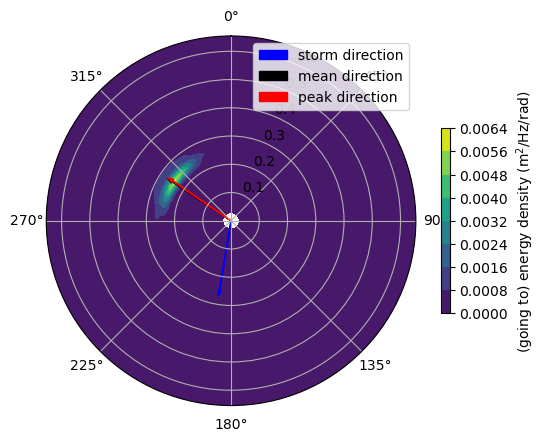

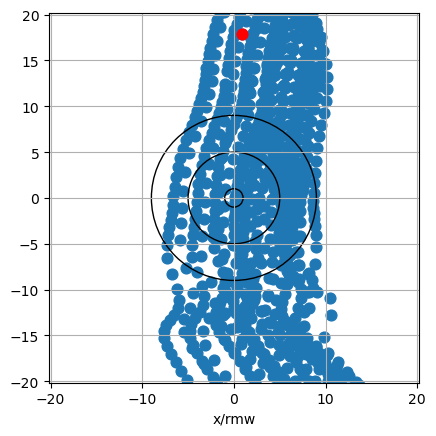

In [99]:
#circle graph
drifter_spectra_2d = spectra_2d_from_df(drifter_df.loc['SPOT-30164D'])#drifter id
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
plot_2d_energy_density(ax, drifter_spectra_2d.sel(time='2023-08-20-T20:00', method='nearest'))#time stamp

#Location visualizer
fig, ax = plt.subplots()


plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm


sc = ax.scatter(x,y, s=60)
ax.set_xlabel('x/rmw')
ax.grid()
circle=plt.Circle((0,0),100)
ax.set_xlim(np.array([-400, 400]) / rmwkm)
ax.set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 





arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()

drifter_id = 'SPOT-30164D'
point_start_time = pd.Timestamp('2023-08-29-T20:00', tz='utc')
point_end_time = point_start_time + pd.Timedelta('1h')
drifter_point = drifter_df.loc[drifter_id][point_start_time:point_end_time]
x = drifter_point.xstorm/rmwkm
y = drifter_point.ystorm/rmwkm
norm = plt.Normalize(0,2)
sc = ax.scatter(x,y,color='r', s=60)

plt.show()


### 2023-08-30-06:00

Reconstructing 2d spectrum with mem2 using solution_method scipy:   0%|                                       …

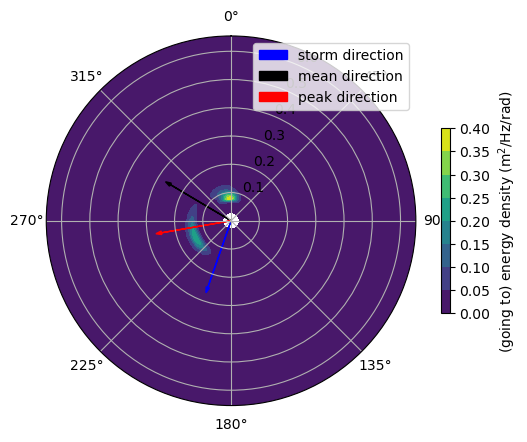

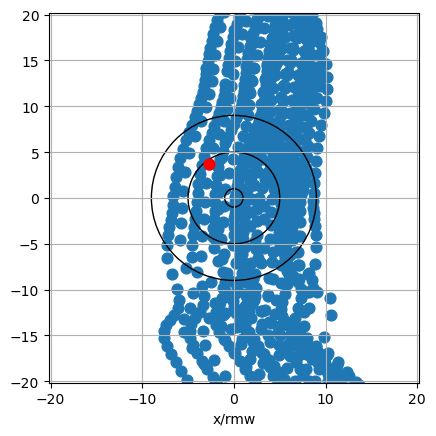

In [100]:
#circle graph
drifter_spectra_2d = spectra_2d_from_df(drifter_df.loc['SPOT-30164D'])#drifter id
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
plot_2d_energy_density(ax, drifter_spectra_2d.sel(time='2023-08-30-T06:00', method='nearest'))#time stamp '2023-08-30-T06:00'


#Location visualizer
fig, ax = plt.subplots()


plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm


sc = ax.scatter(x,y, s=60)
ax.set_xlabel('x/rmw')
ax.grid()
circle=plt.Circle((0,0),100)
ax.set_xlim(np.array([-400, 400]) / rmwkm)
ax.set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 





arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()

drifter_id = 'SPOT-30164D'
point_start_time = pd.Timestamp('2023-08-30-T06:00', tz='utc')
point_end_time = point_start_time + pd.Timedelta('1h')
drifter_point = drifter_df.loc[drifter_id][point_start_time:point_end_time]
x = drifter_point.xstorm/rmwkm
y = drifter_point.ystorm/rmwkm
norm = plt.Normalize(0,2)
sc = ax.scatter(x,y,color='r', s=60)

plt.show()


### 2023-08-30-T08:00

Reconstructing 2d spectrum with mem2 using solution_method scipy:   0%|                                       …

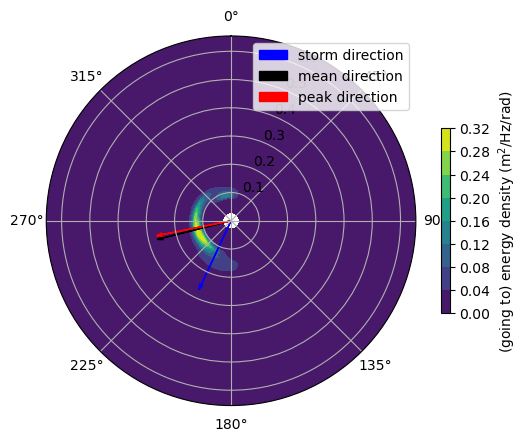

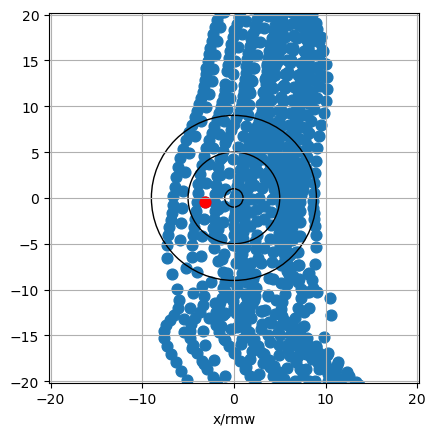

In [101]:
#circle graph
drifter_spectra_2d = spectra_2d_from_df(drifter_df.loc['SPOT-30164D'])#drifter id
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
plot_2d_energy_density(ax, drifter_spectra_2d.sel(time='2023-08-30-T08:00', method='nearest'))#time stamp '2023-08-30-T06:00'


#Location visualizer
fig, ax = plt.subplots()


plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm


sc = ax.scatter(x,y, s=60)
ax.set_xlabel('x/rmw')
ax.grid()
circle=plt.Circle((0,0),100)
ax.set_xlim(np.array([-400, 400]) / rmwkm)
ax.set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 





arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()

drifter_id = 'SPOT-30164D'
point_start_time = pd.Timestamp('2023-08-30-T08:00', tz='utc')
point_end_time = point_start_time + pd.Timedelta('1h')
drifter_point = drifter_df.loc[drifter_id][point_start_time:point_end_time]
x = drifter_point.xstorm/rmwkm
y = drifter_point.ystorm/rmwkm
norm = plt.Normalize(0,2)
sc = ax.scatter(x,y,color='r', s=60)

plt.show()


In [ ]:
#circle graph
drifter_spectra_2d = spectra_2d_from_df(drifter_df.loc['SPOT-30164D'])#drifter id
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
plot_2d_energy_density(ax, drifter_spectra_2d.sel(time='2023-08-30-T12:00', method='nearest'))#time stamp '2023-08-30-T06:00'


#Location visualizer
fig, ax = plt.subplots()


plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm


sc = ax.scatter(x,y, s=60)
ax.set_xlabel('x/rmw')
ax.grid()
circle=plt.Circle((0,0),100)
ax.set_xlim(np.array([-400, 400]) / rmwkm)
ax.set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 





arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()

drifter_id = 'SPOT-30164D'
point_start_time = pd.Timestamp('2023-08-30-T12:00', tz='utc')
point_end_time = point_start_time + pd.Timedelta('1h')
drifter_point = drifter_df.loc[drifter_id][point_start_time:point_end_time]
x = drifter_point.xstorm/rmwkm
y = drifter_point.ystorm/rmwkm
norm = plt.Normalize(0,2)
sc = ax.scatter(x,y,color='r', s=60)

plt.show()


## Data from SPOT-30102D

### 2023-08-29-T20:00

Reconstructing 2d spectrum with mem2 using solution_method scipy:   0%|                                       …

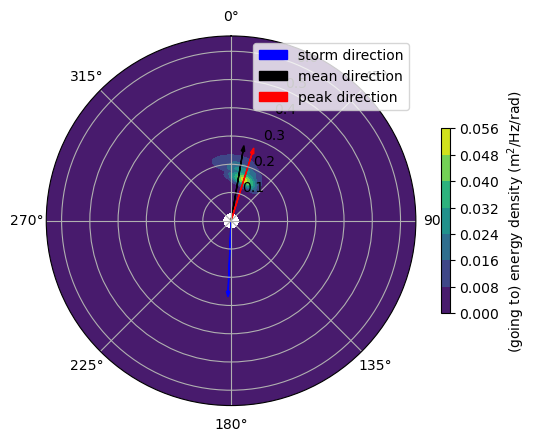

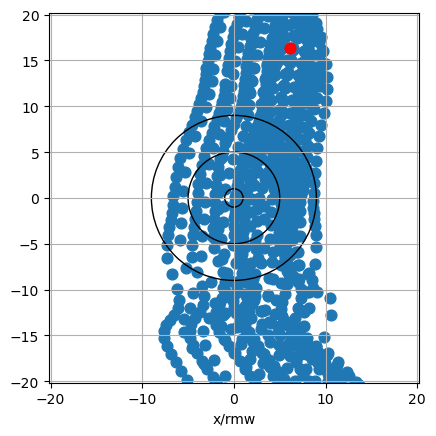

In [108]:
#circle graph
drifter_spectra_2d = spectra_2d_from_df(drifter_df.loc['SPOT-30102D'])#drifter id
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
plot_2d_energy_density(ax, drifter_spectra_2d.sel(time='2023-08-29-T20:00', method='nearest'))#time stamp

#Location visualizer
fig, ax = plt.subplots()


plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm


sc = ax.scatter(x,y, s=60)
ax.set_xlabel('x/rmw')
ax.grid()
circle=plt.Circle((0,0),100)
ax.set_xlim(np.array([-400, 400]) / rmwkm)
ax.set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 





arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()

drifter_id = 'SPOT-30102D'
point_start_time = pd.Timestamp('2023-08-29-T20:00', tz='utc')
point_end_time = point_start_time + pd.Timedelta('1h')
drifter_point = drifter_df.loc[drifter_id][point_start_time:point_end_time]
x = drifter_point.xstorm/rmwkm
y = drifter_point.ystorm/rmwkm
norm = plt.Normalize(0,2)
sc = ax.scatter(x,y,color='r', s=60)

plt.show()


## 2023-08-30-T06:00

Reconstructing 2d spectrum with mem2 using solution_method scipy:   0%|                                       …

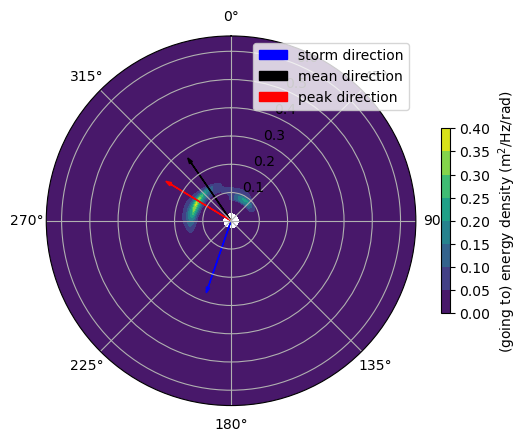

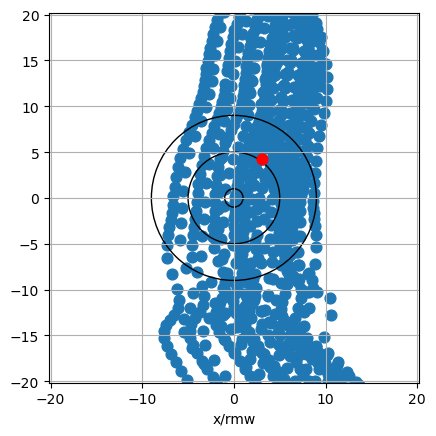

In [114]:
#circle graph
drifter_spectra_2d = spectra_2d_from_df(drifter_df.loc['SPOT-30102D'])#drifter id
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
plot_2d_energy_density(ax, drifter_spectra_2d.sel(time='2023-08-30-T06:00', method='nearest'))#time stamp

#Location visualizer
fig, ax = plt.subplots()


plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm


sc = ax.scatter(x,y, s=60)
ax.set_xlabel('x/rmw')
ax.grid()
circle=plt.Circle((0,0),100)
ax.set_xlim(np.array([-400, 400]) / rmwkm)
ax.set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 





arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()

drifter_id = 'SPOT-30102D'
point_start_time = pd.Timestamp('2023-08-30-T06:00', tz='utc')
point_end_time = point_start_time + pd.Timedelta('1h')
drifter_point = drifter_df.loc[drifter_id][point_start_time:point_end_time]
x = drifter_point.xstorm/rmwkm
y = drifter_point.ystorm/rmwkm
norm = plt.Normalize(0,2)
sc = ax.scatter(x,y,color='r', s=60)

plt.show()


## 2023-08-30-T08:00

Reconstructing 2d spectrum with mem2 using solution_method scipy:   0%|                                       …

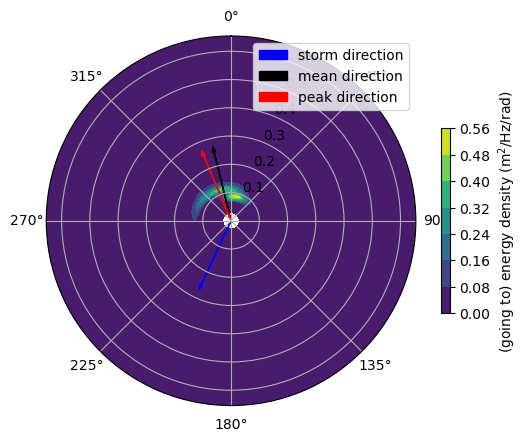

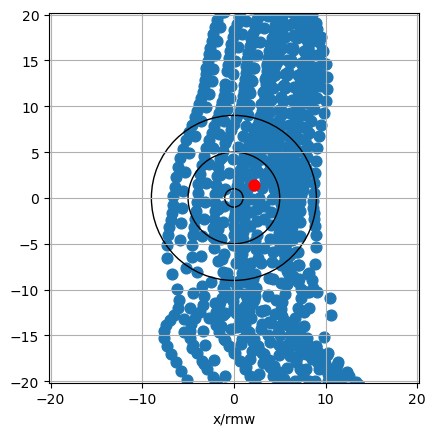

In [116]:
#circle graph
drifter_spectra_2d = spectra_2d_from_df(drifter_df.loc['SPOT-30102D'])#drifter id
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
plot_2d_energy_density(ax, drifter_spectra_2d.sel(time='2023-08-30-T08:00', method='nearest'))#time stamp

#Location visualizer
fig, ax = plt.subplots()


plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm


sc = ax.scatter(x,y, s=60)
ax.set_xlabel('x/rmw')
ax.grid()
circle=plt.Circle((0,0),100)
ax.set_xlim(np.array([-400, 400]) / rmwkm)
ax.set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 





arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()

drifter_id = 'SPOT-30102D'
point_start_time = pd.Timestamp('2023-08-30-T08:00', tz='utc')
point_end_time = point_start_time + pd.Timedelta('1h')
drifter_point = drifter_df.loc[drifter_id][point_start_time:point_end_time]
x = drifter_point.xstorm/rmwkm
y = drifter_point.ystorm/rmwkm
norm = plt.Normalize(0,2)
sc = ax.scatter(x,y,color='r', s=60)

plt.show()

## 2023-08-30-T12:00

Reconstructing 2d spectrum with mem2 using solution_method scipy:   0%|                                       …

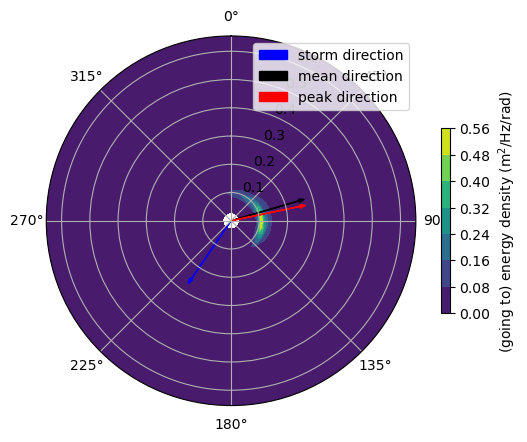

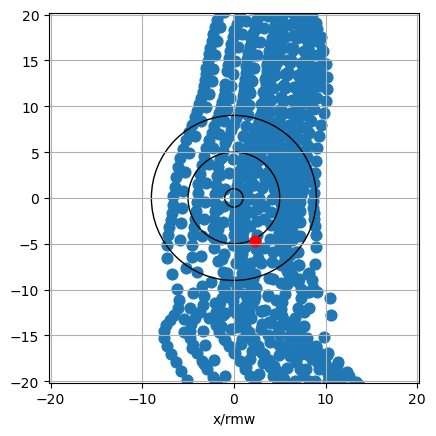

In [117]:
#circle graph
drifter_spectra_2d = spectra_2d_from_df(drifter_df.loc['SPOT-30102D'])#drifter id
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
plot_2d_energy_density(ax, drifter_spectra_2d.sel(time='2023-08-30-T12:00', method='nearest'))#time stamp

#Location visualizer
fig, ax = plt.subplots()


plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm


sc = ax.scatter(x,y, s=60)
ax.set_xlabel('x/rmw')
ax.grid()
circle=plt.Circle((0,0),100)
ax.set_xlim(np.array([-400, 400]) / rmwkm)
ax.set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 





arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()

drifter_id = 'SPOT-30102D'
point_start_time = pd.Timestamp('2023-08-30-T12:00', tz='utc')
point_end_time = point_start_time + pd.Timedelta('1h')
drifter_point = drifter_df.loc[drifter_id][point_start_time:point_end_time]
x = drifter_point.xstorm/rmwkm
y = drifter_point.ystorm/rmwkm
norm = plt.Normalize(0,2)
sc = ax.scatter(x,y,color='r', s=60)

plt.show()